In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from tqdm import tqdm
from quetzal.model import stepmodel
from syspy.skims import skims
from quetzal.io import excel

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


# Emissions modelling
## Saves emissions from passenger transport
## Needs inner- and intra-zonal passenger kilometer by mode

In [3]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]

### Load results

In [5]:
sm = stepmodel.read_zippedpickles(model_path + scenario + '/' + 'de_assignment')
z = stepmodel.read_json(model_path + scenario + '/' + 'de_zones')
sm.zones = z.zones

volumes: 100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:19<00:00,  4.93s/it]


### Road link mapping and vkm

In [6]:
# Filter unused road links
sm.road_links = sm.road_links.loc[(sm.road_links["volume"].notna())
                                  & (sm.road_links["volume"]>0)]
len(sm.road_links)

151383

In [7]:
# Calculate vehicle kilometers by demand segment
# As done in model_assignment_inner-zone
occ_dict = params['car_occ'] # MiD2017 data, see cal10
sm.road_links['vkm'] = sm.road_links["volume"] \
    * sm.road_links['length']/1000 / occ_dict['all']
#for seg in segments:
#    sm.road_links['vkm'] += sm.road_links[(seg, 'car')] \
#        * sm.road_links['length']/1000 / occ_dict[seg]#[0]]
sm.road_links['vkm'] = sm.road_links['vkm'].astype(int)

In [8]:
# Map road volumes to NUTS zones
road_geo = gpd.GeoDataFrame({'NUTS1': np.nan, 'NUTS3': np.nan},
                            index=sm.road_links.index,
                            geometry=[shapely.geometry.Point(g.coords[0])
                                      for g in sm.road_links['geometry']],
                            crs=sm.epsg)
# Map
shapely.speedups.enable()
sm.zones = gpd.GeoDataFrame(sm.zones)
zones = sm.zones.groupby('NUTS_ID')['geometry'].apply(lambda g: g.unary_union)
for zone, geo in tqdm(zones.items(), total=len(zones)):
    road_geo.loc[road_geo['geometry'].within(geo), 'NUTS3'] = zone
road_geo['NUTS1'] = road_geo['NUTS3'].str[:3]

100%|████████████████████████████████████████████████████████████████████████████████| 401/401 [08:33<00:00,  1.28s/it]


In [9]:
# Sum up vkm by region and speed limit
merged = sm.road_links.merge(road_geo['NUTS1'], left_index=True, right_index=True)
inter_car = merged.groupby(['NUTS1', 'maxspeed']).agg({'vkm': 'sum'})

### PT link mapping and pkm

In [10]:
# Drop unused PT links
sm.links = sm.links.loc[(sm.links['volume'].notna()) & (sm.links['volume']>0)]

In [11]:
# Generate length for PT links if not done yet
if 'length' not in sm.links.columns:
    sm.links['length'] = skims.distance_from_geometry(
        sm.links['geometry']).astype(int)

In [12]:
# Emissions from PT are considered in the service's origin
sm.links['NUTS1'] = sm.links['a'].map(sm.nodes['FID'].str[:3])
sm.links['pkm'] = sm.links['length']/1000 * sm.links['volume']
inter_pt = sm.links.groupby(['NUTS1', 'route_type']).agg({'pkm': 'sum'})

### Merge with inner-zonal traffic

In [13]:
# Load results of inner-zonal traffic
inner = pd.read_excel(output_path + 'inner_zone.xlsx', sheet_name='agg', index_col=[0,1])
inner = inner.rename(index={'rail': 'rail_short'})

In [14]:
# Combine results
merged['pkm'] = merged["volume"] * merged['length']/1000
merged['route_type'] = 'car'
all_pkm = merged.groupby(['NUTS1', 'route_type']).agg({'pkm': 'sum'}).append(inter_pt)
inner.index.rename(['NUTS1', 'route_type'], inplace=True)
all_pkm = all_pkm.merge(inner['pkm'], how='outer', left_index=True,
                        right_index=True, suffixes=['_inter', '_inner']).fillna(0)
all_pkm['pkm'] = all_pkm['pkm_inter'] + all_pkm['pkm_inner']

array([<AxesSubplot:ylabel='None'>], dtype=object)

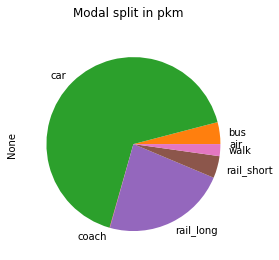

In [15]:
all_pkm['pkm'].unstack().sum(axis=0).plot.pie(subplots=True, title='Modal split in pkm')

In [16]:
print("Mode shares in percent")
mode_agg = {'tram': 'bus', 'subway': 'bus', 'ferry': 'bus', 'funicular': 'bus', 'coach': 'bus',
            'rail_long': 'rail', 'rail_short': 'rail'}
total = all_pkm['pkm'].sum()
print(all_pkm.rename(index=mode_agg).groupby(level=1).agg({'pkm': 'sum'})/total*100)

Mode shares in percent
                  pkm
route_type           
air          0.008849
bus          4.126804
car         66.509784
rail        27.129229
walk         2.225333


In [17]:
print('Total traffic (billion pkm): {}'.format(round(total/1e9,2)))

Total traffic (billion pkm): 1286.46


In [18]:
# Mode shares in total (billion pkm)
print(all_pkm.rename(index=mode_agg).groupby(level=1).agg({'pkm': 'sum'})/1e9)

                   pkm
route_type            
air           0.113842
bus          53.089611
car         855.620636
rail        349.006218
walk         28.627982


In [19]:
# Merge car vkm
car_vkm = inner.xs('car', level=1)[['vkm']].merge(
    inter_car.groupby(level=0).sum()['vkm'], how='outer', left_index=True,
    right_index=True, suffixes=['_inner', '_inter']).fillna(0)
car_vkm['vkm'] = car_vkm['vkm_inter'] + car_vkm['vkm_inner']

In [20]:
# Average vkm per year by roughly 46 Mio. cars in Germany 2017 (GENESIS database)
print(car_vkm['vkm'].sum() / params['vehicles']['car'])

12394.889505460183


In [21]:
# thereof inner model zones
print(car_vkm['vkm_inner'].sum() / params['vehicles']['car'])

1326.5128411979954


In [22]:
# thereof inter model zones
print(car_vkm['vkm_inter'].sum() / params['vehicles']['car'])

11068.376664262189


In [23]:
# Official values for 2017 from TREMOD
656800000000 / params['vehicles']['car']

14290.662368501919

## Calculate PT vehicle loads

While vkm of car traffic are straight forward (using average occupancies and pkm), PT vkm strongly depend on the transport supply system. They can be modelled using average occupancy factors of PT/sharing vehicles (as for private cars), or depend on vehicle circulations that are statically defined in schedules.

Absolute road PT vkm values can be retrieved from BMVI 2018, "Verkehr in Zahlen 2018/19", p. 81. Rail vkm can be generated endogenously using GTFS feeds.

Scientific thoughts regarding a thorough and computational efficient method can be found here: https://doi.org/10.1016/j.procs.2021.03.022

In [24]:
# Use PT load factors calculated from 2018 values.
# They are already included into below emission factors per pkm.

## Calculate emissions from vkm

Reference emissions for 2019 (no change compared to 2017) from passenger traffic in Germany are 164 Mio. tCO2eq * (60.8(car)+1.4(air)+0.3(rail)+XXX(bus)=65)% = 107 Mio. tCO2eq

Source: Bundesministerium für Umwelt, Naturschutz und nukleare Sicherheit (2021): Klimaschutz in Zahlen - Fakten, Trends und Impulse deutscher Klimapolitik Ausgabe 2021, p. 36

Data sources for emission factors in this model are
* vkm car: TREMOD (Transport Emission Model; underlying values come from HBEFA (Handbuch Emissionsfaktoren)): "Aktualisierung der Modelle TREMOD/TREMOD-MM für die Emissionsberichterstattung 2020 (Berichtsperiode 1990-2018)", 2020
* pkm PT: UBA (Umweltbundesamt): "Vergleich der durchschnittlichen Emissionen einzelner Verkehrsmittel im Personenverkehr in Deutschland", 2020

In [25]:
em_dict = params['emissions']

In [26]:
# Cars
# In 2017, there were 66% petrol and 33% diesel cars, rest is mainly LPG (TREMOD, p. 43)
# Take REAL average emissions in gCO2eq/km (TREMOD, p. 54)
car_em = 0.66*173.6 + 0.33*187.6 + 0.01*104
inter_car['tCO2eq'] = inter_car['vkm'] * em_dict['car'] / 1e6

In [27]:
# PT (UBA)
inter_pt['tCO2eq'] = inter_pt['pkm'] * inter_pt.index.get_level_values(1).map(em_dict) / 1e6

In [28]:
# Inner-zonal
mask = (inner.index.get_level_values(1)=='car')
inner.loc[mask,'tCO2eq'] = inner.loc[mask,'vkm'] * \
    inner.loc[mask].index.get_level_values(1).map(em_dict) / 1e6
inner.loc[~mask,'tCO2eq'] = inner.loc[~mask,'pkm'] * \
    inner.loc[~mask].index.get_level_values(1).map(em_dict) / 1e6

In [29]:
print('Local transport emissions (mio. tonnes): {}'.format(
    inner.groupby('route_type').agg({'tCO2eq': 'sum'}) / 1e6))

Local transport emissions (mio. tonnes):                tCO2eq
route_type           
bus          2.742784
car         10.823041
rail_short   0.727641
walk         0.000000


In [30]:
print("CAR: Long-distance transport emissions (mio. tonnes): {}".format(
    inter_car['tCO2eq'].sum()/1e6))

CAR: Long-distance transport emissions (mio. tonnes): 90.30707800868267


In [31]:
print("PT: Long-distance transport emissions (mio. tonnes): {}".format(
    inter_pt.groupby('route_type').agg({'tCO2eq': 'sum'}) / 1e6))

PT: Long-distance transport emissions (mio. tonnes):               tCO2eq
route_type          
air         0.024362
bus         1.428464
coach       0.030368
rail_long   8.593508
rail_short  2.169669


In [32]:
# Drop speeds in car km
inter_car = inter_car.groupby(level=0).sum()
inter_car['route_type'] = 'car'
inter_car.set_index('route_type', append=True, inplace=True)

In [33]:
# Merge emissions together
all_em = inter_pt[['tCO2eq']].append(inter_car[['tCO2eq']]).append(inner[['tCO2eq']])
all_em = all_em.groupby(level=[0,1]).sum()

<AxesSubplot:xlabel='NUTS1'>

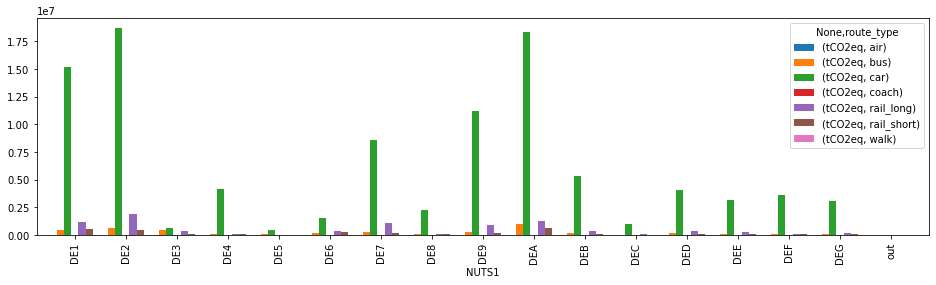

In [34]:
# Emissions by region and mode
all_em.unstack().plot.bar(subplots=False, figsize=(16,4), width=1)

## Save
Create one ecxel output with pkm, emissions, time and cost.

In [35]:
# Load inter-zonal aggregated results
inter = pd.read_excel(output_path + scenario + '/' + 'inter_zone.xlsx',
                      sheet_name='od', index_col=[0,1,2])
# Get time and price weighted averages by origin and mode
weighted_av = lambda x: np.average(x, weights=inter.loc[x.index, 'volumes'])
inter = inter.groupby(level=[0,2]).agg(
    volumes=('volumes', 'sum'),
    time=('time', weighted_av))
inter.index.rename(['NUTS1', 'route_type'], inplace=True)

In [36]:
# Sums
for col in ['time']:
    inter[col] = inter[col] * inter['volumes']
inter.sample()

,,volumes,time
NUTS1,route_type,,
DE2,air,53934.093041,356090.633024


In [37]:
# Merge times
time = inter[['time']].merge(
    (inner['time']*inner['volumes']).rename('time'), how='outer',
    left_index=True, right_index=True, suffixes=['_inter', '_inner']).fillna(0)
time['time'] = time['time_inter'] + time['time_inner']

In [38]:
# Average car operating hours per day per car
time.xs('car', level=1)['time'].sum() / params['vehicles']['car'] / 365

1.0942033268623925

In [39]:
# Merge prices
if 'price' in inter.columns:
    price = inter[['price']].merge(
        (inner['price']*inner['volumes']).rename('price'), how='outer',
        left_index=True, right_index=True, suffixes=['_inter', '_inner']).fillna(0)
    price['price'] = price['price_inter'] + price['price_inner']

In [40]:
# Save excel
with pd.ExcelWriter(output_path + scenario + '/' + 'results_agg.xlsx') as writer:  
    all_pkm.to_excel(writer, sheet_name='pkm')
    car_vkm.to_excel(writer, sheet_name='car_vkm')
    all_em.to_excel(writer, sheet_name='emissions')
    time.to_excel(writer, sheet_name='time')
    if 'price' in inter.columns: price.to_excel(writer, sheet_name='price')

### Save disaggregated results

In [41]:
# Sum up car pkm by region
merged = sm.road_links.merge(road_geo['NUTS3'], left_index=True, right_index=True)
merged['pkm'] = merged["volume"] * merged['length']/1000
inter_car = merged.groupby('NUTS3').agg({"pkm": 'sum'})

In [42]:
# PT
sm.links['NUTS3'] = sm.links['a'].map(sm.nodes['FID'])
sm.links['pkm'] = sm.links['length']/1000 * sm.links['volume']
inter_pt = sm.links.groupby(['NUTS3', 'route_type']).agg({'pkm': 'sum'})

In [43]:
# Load inner-zonal disaggregated pkm
inner = pd.read_csv(output_path + 'inner_zone_pkm.csv')
inner = inner.replace({'rail': 'rail_short'})
inner = inner.groupby(['origin', 'mode']).agg({'pkm': 'sum'})

In [44]:
# All together
inter_car['route_type'] = 'car'
inter = inter_car.groupby(['NUTS3', 'route_type']).agg({'pkm': 'sum'}).append(inter_pt)
inter.index.names = inner.index.names
all_pkm = inner.merge(inter, how='outer', left_index=True, right_index=True).fillna(0)

In [45]:
all_pkm['pkm'] = all_pkm['pkm_x'] + all_pkm['pkm_y']

In [46]:
all_pkm[['pkm']].to_csv(output_path + scenario + '/' + 'pkm.csv')